In [89]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

# Estatística e análise
import scipy.stats as stats
from scipy.stats import fisher_exact, linregress
from itertools import combinations

# Geoprocessamento
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
from geobr import read_state

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

# Otimização
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Conexão com banco de dados
import psycopg2

# Configurações e ajustes
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configurações de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)


# CONTRATOS

In [90]:
# contratos
conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

cursor.execute(f"""

    SELECT 
        f.type,
        public.freights_type(f.type) AS type_descricao,
        CASE
            WHEN f.type::INTEGER = 2 THEN 'ajudante'
            WHEN f.type::INTEGER = 3 THEN 'curta'
            ELSE 'longa'
        END AS categoria, 
        f.status,
        public.freights_status(f.status) AS status_descricao,
        CASE 
            WHEN f.status = 900 THEN 'sim'
            ELSE 'nao'
        END AS foi_cancelada, 
        f.start_at,
        f.id AS freight_id,
        f.price / 100 AS price,
        f.contract_days,
        f.company_id,
        ca.latitude AS origin_latitude,
        ca.longitude AS origin_longitude,
        CASE 
            WHEN uwf.freight_id IS NOT NULL THEN 'sim'
            ELSE 'nao'
        END AS atuacao_falcon,
        c.created_at AS company_created_at,
        c.updated_at AS company_updated_at,
        c.client_status AS company_status,
        public.companies_client_status(c.client_status) AS company_descricao,
        c.status_changed_at AS company_status_changed_at
    FROM freights f
    LEFT JOIN company_addresses ca ON ca.id = f.origin
    LEFT JOIN (
        SELECT DISTINCT freight_id
        FROM user_working_freights
    ) uwf ON uwf.freight_id = f.id
    LEFT JOIN companies c ON c.id = f.company_id
    WHERE f.start_at >= '2024-07-01'
      AND f.start_at < CURRENT_DATE
      AND f.company_id NOT IN (
          SELECT id 
          FROM companies 
          WHERE company_multitenancy_id = 5
      )
    ORDER BY f.start_at ASC;
""")


contratos = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
contratos = pd.DataFrame(contratos, columns=colnames)

cursor.close()
conn.close()

contratos['mes'] = pd.to_datetime(contratos['start_at']).dt.to_period('M').dt.to_timestamp()

# ibge_meso - Mesoregioes
ibge_meso = gpd.read_file("BR_Mesorregioes_2022/BR_Mesorregioes_2022.shp").rename(columns={'NM_MESO': 'meso', 'SIGLA_UF': 'estado', 'geometry': 'geometry_meso'})
ibge_meso = ibge_meso[['meso', 'geometry_meso', 'estado']]
ibge_meso = ibge_meso.set_geometry('geometry_meso') 
ibge_meso = ibge_meso.to_crs(epsg=4326)

contratos["geometry_meso"] = contratos.apply(lambda row: Point(row["origin_longitude"], row["origin_latitude"]), axis=1)
gdf_contratos = gpd.GeoDataFrame(contratos, geometry="geometry_meso", crs="EPSG:4326") 
ibge = ibge_meso.to_crs(gdf_contratos.crs)
contratos = gpd.sjoin(gdf_contratos, ibge_meso, predicate="within", how="left")

contratos = contratos[['mes', 'categoria', 'foi_cancelada', 'atuacao_falcon', 'company_descricao','freight_id', 'price','contract_days','company_id','meso', 'estado']]

contratos = contratos.loc[contratos.mes < '2025-03-01']
contratos.to_csv('contratos.csv', index=False)
contratos

,mes,categoria,foi_cancelada,atuacao_falcon,company_descricao,freight_id,price,contract_days,company_id,meso,estado
0,2024-07-01,ajudante,sim,nao,Inativo,90890,1500,3,2426,Metropolitana de Porto Alegre,RS
1,2024-07-01,ajudante,sim,nao,Inativo,90877,1500,3,2426,Metropolitana de Porto Alegre,RS
2,2024-07-01,ajudante,sim,nao,Inativo,90892,1500,3,2426,Metropolitana de Porto Alegre,RS
3,2024-07-01,longa,nao,nao,Ativo,89871,5320,19,2843,Norte Central Paranaense,PR
4,2024-07-01,longa,nao,nao,Recorrente,90971,1400,5,704,Metropolitana de São Paulo,SP
...,...,...,...,...,...,...,...,...,...,...,...
47023,2025-02-01,longa,nao,nao,Recorrente,146476,1860,5,3746,Metropolitana de São Paulo,SP
47024,2025-02-01,longa,nao,nao,Recorrente,146287,1674,5,2124,Macro Metropolitana Paulista,SP
47025,2025-02-01,longa,nao,nao,Recorrente,146516,744,2,3746,Metropolitana de São Paulo,SP
47026,2025-02-01,longa,nao,sim,Recorrente,146518,1116,3,3746,Metropolitana de São Paulo,SP


In [91]:
# porcentagem_cancelamentos
contratos_cancelados = contratos.groupby(['mes', 'foi_cancelada', 'atuacao_falcon','meso', 'estado'])['freight_id'].count().reset_index()
contratos_cancelados = contratos_cancelados.rename(columns={'freight_id': 'total_contratos'})


taxa_cancelamento_falcon = contratos_cancelados.groupby(['meso', 'atuacao_falcon']).apply(
    lambda x: (x['foi_cancelada'] == 'sim').sum() / x['total_contratos'].sum()).reset_index()
taxa_cancelamento_falcon.columns = ['meso', 'atuacao_falcon', 'taxa_cancelamento']


porcentagem_cancelamentos = taxa_cancelamento_falcon.pivot_table(
    index='meso',
    columns='atuacao_falcon',
    values='taxa_cancelamento',
    fill_value=0).reset_index()

porcentagem_cancelamentos.columns = ['meso', 'cancelamento_sem_falcon', 'cancelamento_com_falcon']

porcentagem_cancelamentos.head(3)

,meso,cancelamento_sem_falcon,cancelamento_com_falcon
0,Agreste Alagoano,0.18,0.33
1,Agreste Paraibano,0.10,0.09
2,Agreste Pernambucano,0.10,0.33


In [92]:
# tendencias_meso

total_contratos_meso = contratos.groupby(['mes', 'meso', 'categoria'])['freight_id'].count().reset_index()
total_contratos_meso = total_contratos_meso.rename(columns={'freight_id': 'total_contratos_meso'})


total_contratos_meso_pivot = total_contratos_meso.pivot_table(
    index=['mes', 'meso'],
    columns='categoria',
    values='total_contratos_meso',
    fill_value=0
).reset_index()

total_contratos_meso_pivot = total_contratos_meso_pivot.rename(columns={
    'longa': 'qt_longa',
    'curta': 'qt_curta',
    'ajudante': 'qt_ajudante'
})


total_contratos_meso_pivot['qt_contratos_total'] = total_contratos_meso_pivot['qt_curta'] + total_contratos_meso_pivot['qt_longa']  + total_contratos_meso_pivot['qt_ajudante']

total_contratos_meso_pivot['porc_ajudante'] = total_contratos_meso_pivot['qt_ajudante'] / total_contratos_meso_pivot['qt_contratos_total']
total_contratos_meso_pivot['porc_curta'] = total_contratos_meso_pivot['qt_curta'] / total_contratos_meso_pivot['qt_contratos_total']
total_contratos_meso_pivot['porc_longa'] = total_contratos_meso_pivot['qt_longa'] / total_contratos_meso_pivot['qt_contratos_total']


total_contratos_meso_pivot['contrato_principal'] = total_contratos_meso_pivot[['porc_ajudante', 'porc_curta', 'porc_longa']].idxmax(axis=1)
total_contratos_meso_pivot['contrato_principal'] = total_contratos_meso_pivot['contrato_principal'].str.replace('porc_', '')

total_contratos_meso_pivot.to_csv('total_contratos_meso_pivot.csv', index=False)



total_contratos_meso_pivot['mes'] = pd.to_datetime(total_contratos_meso_pivot['mes'])


colunas_analise = [ 'qt_ajudante', 'qt_curta', 'qt_longa','porc_ajudante', 'porc_curta', 'porc_longa']

# Calcular a tendência (coeficiente angular da regressão linear) para cada mesorregião e coluna
tendencias = []

for meso, grupo in total_contratos_meso_pivot.groupby('meso'):
    for coluna in colunas_analise:
        # Converter o tempo em número ordinal para regressão linear
        x = grupo['mes'].map(pd.Timestamp.toordinal)
        y = grupo[coluna]
        
        # Calcular a regressão linear
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Adicionar o resultado à lista
        tendencias.append({
            'meso': meso,
            'coluna': coluna,
            'tendencia': slope,
            'p_valor': p_value,
            'significativo': p_value < 0.05  # Considerar p < 0.05 como tendência significativa
        })

tendencias_df = pd.DataFrame(tendencias)


tendencias_df['tipo_tendencia'] = tendencias_df.apply(
    lambda row: (
        'aumento' if row['significativo'] and row['tendencia'] > 0 else
        'reducao' if row['significativo'] and row['tendencia'] < 0 else
        'NS'),
    axis=1)


tendencias_meso = tendencias_df.pivot(
    index='meso',
    columns='coluna',
    values='tipo_tendencia'
).reset_index()

tendencias_ = tendencias_meso.fillna('NS')

tendencias_meso.head(3)

coluna,meso,porc_ajudante,porc_curta,porc_longa,qt_ajudante,qt_curta,qt_longa
0,Agreste Alagoano,NS,NS,NS,NS,NS,NS
1,Agreste Paraibano,NS,NS,NS,NS,NS,NS
2,Agreste Pernambucano,NS,reducao,NS,NS,NS,NS


In [93]:
# contratos_count
contratos_count = contratos.groupby(['mes', 'meso', 'categoria']).agg(
    contratos=('freight_id', 'nunique'),  # Contratos únicos
    cancelamentos=('foi_cancelada', lambda x: (x == 'sim').sum()),
    atuacoes_falcon=('atuacao_falcon', lambda x: (x == 'sim').sum()),
    empresas=('company_id', 'nunique')  # Empresas únicas
).reset_index()

contratos_count.head(3)


,mes,meso,categoria,contratos,cancelamentos,atuacoes_falcon,empresas
0,2024-07-01,Agreste Pernambucano,curta,4,0,1,1
1,2024-07-01,Agreste Pernambucano,longa,1,1,1,1
2,2024-07-01,Araçatuba,curta,8,0,3,1


In [94]:
# contratos_falcon_por_mes
contratos_falcon_por_mes = (
    contratos[contratos['atuacao_falcon'] == 'sim']
    .groupby(['mes'])
    .size()
    .reset_index(name='qt_contratos_falcon')
)

contratos_falcon_por_mes

,mes,qt_contratos_falcon
0,2024-07-01,1530
1,2024-08-01,1752
2,2024-09-01,2723
3,2024-10-01,2902
4,2024-11-01,3541
5,2024-12-01,3564
6,2025-01-01,2186
7,2025-02-01,754


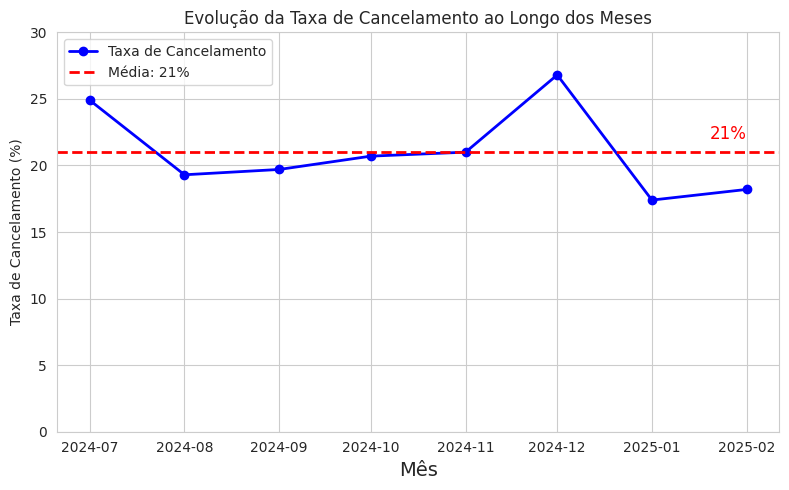

In [95]:
# cancelamentos_por_mes
cancelamentos_por_mes = contratos.groupby(['mes', 'foi_cancelada']).size().unstack(fill_value=0)
cancelamentos_por_mes['total'] = cancelamentos_por_mes.sum(axis=1)
cancelamentos_por_mes['taxa_cancelamento'] = ((cancelamentos_por_mes['sim'] / cancelamentos_por_mes['total']) * 100).round(1)
cancelamentos_por_mes = cancelamentos_por_mes.reset_index()

# Calcular a média da taxa de cancelamento
media_cancelamento = cancelamentos_por_mes['taxa_cancelamento'].mean()

# Configurar o estilo do gráfico para apresentação executiva
plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')

# Criar o gráfico de linha com o eixo Y ajustado
plt.plot(cancelamentos_por_mes['mes'], cancelamentos_por_mes['taxa_cancelamento'], marker='o', linestyle='-', color='b', linewidth=2, label='Taxa de Cancelamento')

# Adicionar a linha da média em vermelho
plt.axhline(y=media_cancelamento, color='r', linestyle='--', linewidth=2, label=f'Média: {media_cancelamento:.0f}%')

# Adicionar o valor da média no gráfico
plt.text(cancelamentos_por_mes['mes'].iloc[-1], media_cancelamento + 1, f'{media_cancelamento:.0f}%', color='r', fontsize=12, ha='right')

# Personalizar o gráfico
plt.title('Evolução da Taxa de Cancelamento ao Longo dos Meses')
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Taxa de Cancelamento (%)')
plt.xticks(rotation=0)
plt.ylim(0, 30)  # Ajustar o eixo Y de 0 a 30
plt.grid(True)
plt.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()




In [96]:
# Anaĺises iniciais da base

# 1. Calcular a taxa de sucesso do Falcon: contratos não cancelados com atuação do Falcon
taxa_sucesso_falcon = contratos.groupby('atuacao_falcon')['foi_cancelada'].apply(lambda x: (x == 'nao').sum() / x.count()).reset_index()
taxa_sucesso_falcon.columns = ['atuacao_falcon', 'taxa_sucesso']
taxa_sucesso_falcon



# 3. Verificar a atuação do Falcon por categoria e região
atuacao_categoria_regiao = contratos.groupby(['categoria', 'meso', 'atuacao_falcon'])['foi_cancelada'].apply(lambda x: (x == 'nao').sum() / x.count()).reset_index()
atuacao_categoria_regiao.columns = ['categoria', 'meso', 'atuacao_falcon', 'taxa_sucesso']

# 4. Análise de impacto financeiro: Calcular o valor salvo pelo Falcon ao evitar cancelamentos
# Supondo que o preço seja o valor perdido em um cancelamento, calcular o valor salvo
valor_salvo = contratos.loc[(contratos['foi_cancelada'] == 'nao') & (contratos['atuacao_falcon'] == 'sim')]['price'].sum()
meses_unicos = contratos['mes'].nunique()
media_mensal = valor_salvo / meses_unicos if meses_unicos > 0 else 0
valor_salvo = f"R$ {valor_salvo:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
media_mensal = f"R$ {media_mensal:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")


# Exibir os resultados para o usuário
print("Taxa de Sucesso do Falcon")
display(taxa_sucesso_falcon.head(3))
print("Cancelamentos por Mês")
display(cancelamentos_por_mes.reset_index())
print("Atuação do Falcon por Categoria e Região")
display(atuacao_categoria_regiao)
print(f"A atuação do Falcon ajudou a salvar contratos que representam um valor total de {valor_salvo} reais.")
print(f"Isto representa uma média de {media_mensal} reais por mês.")

Taxa de Sucesso do Falcon


,atuacao_falcon,taxa_sucesso
0,nao,0.84
1,sim,0.72


Cancelamentos por Mês


foi_cancelada,index,mes,nao,sim,total,taxa_cancelamento
0,0,2024-07-01,3509,1163,4672,24.90
1,1,2024-08-01,3580,854,4434,19.30
2,2,2024-09-01,4168,1024,5192,19.70
3,3,2024-10-01,4626,1208,5834,20.70
4,4,2024-11-01,4961,1315,6276,21.00
5,5,2024-12-01,5129,1881,7010,26.80
6,6,2025-01-01,5455,1153,6608,17.40
7,7,2025-02-01,5725,1277,7002,18.20


Atuação do Falcon por Categoria e Região


,categoria,meso,atuacao_falcon,taxa_sucesso
0,ajudante,Agreste Alagoano,nao,0.44
1,ajudante,Agreste Alagoano,sim,0.40
2,ajudante,Agreste Paraibano,nao,0.44
3,ajudante,Agreste Paraibano,sim,0.33
4,ajudante,Agreste Pernambucano,nao,0.25
...,...,...,...,...
499,longa,Vale do Paraíba Paulista,sim,0.87
500,longa,Vale do Rio Doce,nao,0.84
501,longa,Vale do Rio Doce,sim,0.65
502,longa,Zona da Mata,nao,0.96


A atuação do Falcon ajudou a salvar contratos que representam um valor total de R$ 47.293.474,00 reais.
Isto representa uma média de R$ 5.911.684,25 reais por mês.


# TAXAS

In [97]:
# taxas

# taxa_atendimento
taxa_atendimento = (
    contratos.groupby(['mes', 'meso' ])['foi_cancelada']
    .apply(lambda x: (x == 'nao').sum() / x.count())
    .reset_index(name='taxa_atendimento'))

# taxa_retencao
status_continua = ["Recorrente", "Ativo"]
contratos['cliente_retido'] = contratos['company_descricao'].isin(status_continua)

taxa_retencao = contratos.groupby(['meso', 'mes']).agg(
    total_clientes=('company_id', 'nunique'),
    clientes_retidos=('cliente_retido', 'sum')
).reset_index()

taxa_retencao['taxa_retencao'] = taxa_retencao['clientes_retidos'] / taxa_retencao['total_clientes']
taxa_retencao = taxa_retencao[['mes', 'meso',  'taxa_retencao']]

# taxa_falcon
taxa_falcon = (
    contratos.groupby(['mes', 'meso'])['atuacao_falcon']
    .apply(lambda x: (x == 'sim').sum() / x.count())
    .reset_index(name='taxa_falcon'))


# taxas
taxas = taxa_atendimento.merge(taxa_retencao , on=[ 'mes','meso'], how='left')
taxas = taxas.merge(taxa_falcon , on=[ 'mes','meso'], how='left')

taxas.head(3)

,mes,meso,taxa_atendimento,taxa_retencao,taxa_falcon
0,2024-07-01,Agreste Pernambucano,0.80,0.00,0.40
1,2024-07-01,Araçatuba,0.92,1.33,0.33
2,2024-07-01,Assis,1.00,0.50,1.00


In [98]:
# taxas_medias

taxas_medias = taxas.groupby([ "meso"], as_index=False).agg({
    "taxa_atendimento": "mean",
    "taxa_retencao": "mean",
    "taxa_falcon": "mean",})

# normalizando para que fiquem no inervalo [0,1]
columns_to_normalize = ['taxa_atendimento', 'taxa_retencao', 'taxa_falcon']

# Criar o normalizador Min-Max
scaler = MinMaxScaler()
taxas_medias[columns_to_normalize] = scaler.fit_transform(taxas_medias[columns_to_normalize])
taxas_medias.to_csv('taxas_medias.csv', index=False)
taxas_medias.head(3)

,meso,taxa_atendimento,taxa_retencao,taxa_falcon
0,Agreste Alagoano,0.42,0.19,0.17
1,Agreste Paraibano,0.50,0.68,0.39
2,Agreste Pernambucano,0.72,0.00,0.41


In [99]:
taxas_medias.meso.count()

120

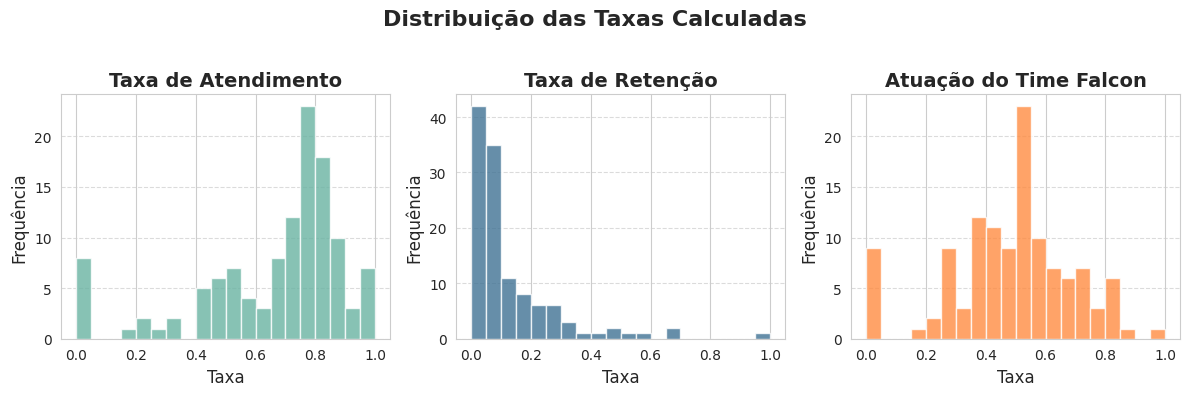

In [100]:
# Gráficos
plt.figure(figsize=(12, 4))

# Usar uma paleta de cores mais suave
colors = ['#69b3a2', '#407294', '#ff8c42']
titles = [
    'Taxa de Atendimento',
    'Taxa de Retenção',
    'Atuação do Time Falcon'
]
columns_to_plot= ['taxa_atendimento', 'taxa_retencao', 'taxa_falcon']
for i, (column, color, title) in enumerate(zip(columns_to_plot, colors, titles), 1):
    plt.subplot(1, 3, i)
    plt.hist(taxas_medias[column], bins=20, color=color, edgecolor='white', alpha=0.8)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Taxa', fontsize=12)
    plt.ylabel('Frequência', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Distribuição das Taxas Calculadas', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# PCA

In [101]:
# pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer

df = taxas_medias.copy()

# Selecionar as colunas para padronização
columns_to_scale = ['taxa_atendimento', 'taxa_retencao', 'taxa_falcon']

# Padronizar as colunas selecionadas
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Aplicar o PCA com as colunas padronizadas e transformadas
columns_for_pca = ['taxa_atendimento', 'taxa_retencao', 'taxa_falcon']

pca = PCA(n_components=3)
df_pca = pca.fit_transform(df[columns_for_pca])

# Adicionar os componentes principais ao DataFrame
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['meso'] = df['meso']

# Exibir a variância explicada por cada componente
print('Variância explicada por componente:', pca.explained_variance_ratio_)


Variância explicada por componente: [0.42552756 0.34666323 0.22780921]


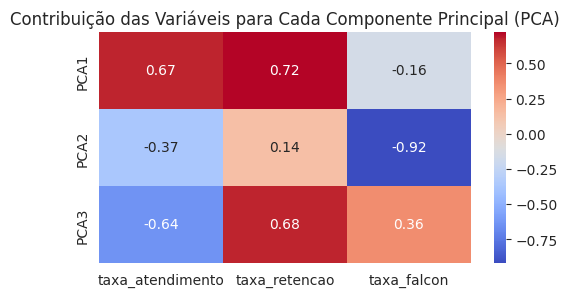

In [102]:
# Exibir os componentes principais e os pesos das variáveis
pca_components = pd.DataFrame(pca.components_, 
                              columns=columns_for_pca, 
                              index=[f'PCA{i+1}' for i in range(pca.n_components_)])

plt.figure(figsize=(6, 3))
sns.heatmap(pca_components, cmap='coolwarm', annot=True)
plt.title('Contribuição das Variáveis para Cada Componente Principal (PCA)')
plt.show()

### **Análise dos Componentes Principais (PCA)**

**Componente PCA1 (42,5% da Variância)**  
- Alta correlação positiva com **taxa_atendimento** (+0,67) e **taxa_retencao** (+0,72).
- Baixa correlação com **taxa_falcon** (-0,16).
- **Interpretação:** Representa regiões onde o atendimento e a retenção são altos, mas a atuação do Falcon é menos relevante. 
Essas são áreas com boa performance natural, onde o Falcon pode atuar de forma mais pontual ou até mesmo não ser necessário.

**Componente PCA2 (34,6% da Variância)**  
- Correlação negativa com **taxa_atendimento** (-0,37) e forte correlação negativa com **taxa_falcon** (-0,92).
- Correlação neutra com **taxa_retencao** (+0,14).
- **Interpretação:** Foco na atuação do Falcon em cenários onde o atendimento é baixo. A atuação do Falcon aqui é crítica para evitar quedas no desempenho, especialmente em situações de baixo atendimento.

**Componente PCA3 (22,8% da Variância)**  
- Correlação negativa com **taxa_atendimento** (-0,64) e positiva com **taxa_retencao** (+0,68) e **taxa_falcon** (+0,36).
- **Interpretação:** Representa cenários mistos, onde o Falcon atua em regiões de baixa taxa de atendimento, mas consegue manter uma retenção média. 
Indica uma atuação mais estratégica, possivelmente para contratos específicos ou regiões desafiadoras.

# PCA PREDOMINANTE

In [103]:
# meso_pca_completo

meso_pca = pd.merge(df_pca, taxas_medias, on='meso', how='inner')
meso_pca['PCA_predominante'] = meso_pca[['PCA1', 'PCA2', 'PCA3']].abs().idxmax(axis=1)

meso_pca_completo = pd.merge(meso_pca, tendencias_meso,  on='meso', how='left')
meso_pca_completo = meso_pca_completo[[ 'meso', 'taxa_atendimento',	'taxa_retencao','taxa_falcon','PCA_predominante','porc_ajudante', 'porc_curta', 'porc_longa', 'qt_ajudante', 'qt_curta','qt_longa']]
meso_pca_completo = pd.merge(meso_pca_completo, porcentagem_cancelamentos,  on='meso', how='left')

meso_pca_completo_para_merge = meso_pca_completo[['meso','PCA_predominante']]
meso_pca_completo.head(3)

,meso,taxa_atendimento,taxa_retencao,taxa_falcon,PCA_predominante,porc_ajudante,porc_curta,porc_longa,qt_ajudante,qt_curta,qt_longa,cancelamento_sem_falcon,cancelamento_com_falcon
0,Agreste Alagoano,0.42,0.19,0.17,PCA2,NS,NS,NS,NS,NS,NS,0.18,0.33
1,Agreste Paraibano,0.50,0.68,0.39,PCA3,NS,NS,NS,NS,NS,NS,0.10,0.09
2,Agreste Pernambucano,0.72,0.00,0.41,PCA3,NS,reducao,NS,NS,NS,NS,0.10,0.33


In [104]:
meso_pca_completo.PCA_predominante.value_counts()

PCA_predominante
PCA1    49
PCA2    43
PCA3    28
Name: count, dtype: int64

In [105]:
# frequencia_tendencias

tendencia_por_pca = pd.melt(
    meso_pca_completo, 
    id_vars=['PCA_predominante'], 
    value_vars=['porc_ajudante', 'porc_curta', 'porc_longa', 'qt_ajudante', 'qt_curta', 'qt_longa'],
    var_name='coluna',
    value_name='tipo_tendencia')

frequencia_tendencias = tendencia_por_pca.groupby(['PCA_predominante', 'coluna', 'tipo_tendencia']).size().reset_index(name='frequencia')
frequencia_tendencias


,PCA_predominante,coluna,tipo_tendencia,frequencia
0,PCA1,porc_ajudante,NS,42
1,PCA1,porc_ajudante,aumento,5
2,PCA1,porc_ajudante,reducao,2
3,PCA1,porc_curta,NS,38
4,PCA1,porc_curta,aumento,5
5,PCA1,porc_curta,reducao,6
6,PCA1,porc_longa,NS,41
7,PCA1,porc_longa,aumento,3
8,PCA1,porc_longa,reducao,5
9,PCA1,qt_ajudante,NS,42


In [106]:
# Calcular as métricas de comportamento das taxas de cancelamento por PCA predominante
comportamento_cancelamento = meso_pca_completo.groupby('PCA_predominante').agg(
    media_cancelamento_sem_falcon=('cancelamento_sem_falcon', 'mean'),
    media_cancelamento_com_falcon=('cancelamento_com_falcon', 'mean'),
    min_cancelamento_sem_falcon=('cancelamento_sem_falcon', 'min'),
    max_cancelamento_sem_falcon=('cancelamento_sem_falcon', 'max'),
    min_cancelamento_com_falcon=('cancelamento_com_falcon', 'min'),
    max_cancelamento_com_falcon=('cancelamento_com_falcon', 'max')
).reset_index()

# Exibir o resultado
comportamento_cancelamento


,PCA_predominante,media_cancelamento_sem_falcon,media_cancelamento_com_falcon,min_cancelamento_sem_falcon,max_cancelamento_sem_falcon,min_cancelamento_com_falcon,max_cancelamento_com_falcon
0,PCA1,0.25,0.28,0.00,1.00,0.00,1.00
1,PCA2,0.27,0.15,0.00,1.00,0.00,0.50
2,PCA3,0.10,0.13,0.00,0.40,0.00,0.50


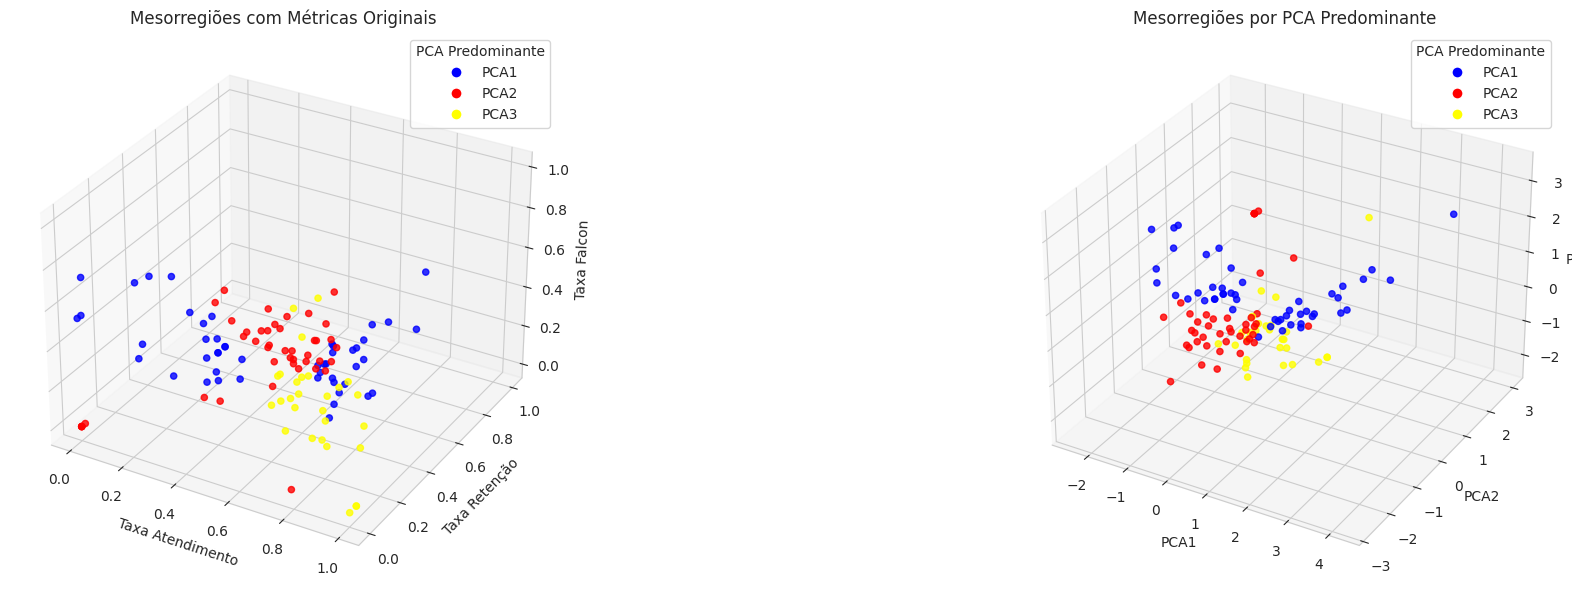

In [107]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import pandas as pd

# Supondo que 'meso_pca' já esteja disponível no contexto
# Se precisar carregar os dados, substitua essa linha pelo carregamento adequado
data = meso_pca

# Mapear as categorias para números
pca_map = {'PCA1': 0, 'PCA2': 1, 'PCA3': 2}
data['PCA_predominante_num'] = data['PCA_predominante'].map(pca_map)

# Cores fixas para cada PCA
colors = {0: 'blue', 1: 'red', 2: 'yellow'}

# Criando a figura com dois gráficos lado a lado
fig = plt.figure(figsize=(24, 6))

# Gráfico 1: Métricas Originais
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(data['taxa_atendimento'], 
                       data['taxa_retencao'], 
                       data['taxa_falcon'], 
                       c=data['PCA_predominante_num'].map(colors), alpha=0.8)

ax1.set_title('Mesorregiões com Métricas Originais')
ax1.set_xlabel('Taxa Atendimento')
ax1.set_ylabel('Taxa Retenção')
ax1.set_zlabel('Taxa Falcon')

# Gráfico 2: PCA Predominante
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(data['PCA1'], data['PCA2'], data['PCA3'], 
                       c=data['PCA_predominante_num'].map(colors), alpha=0.8)

ax2.set_title('Mesorregiões por PCA Predominante')
ax2.set_xlabel('PCA1')
ax2.set_ylabel('PCA2')
ax2.set_zlabel('PCA3')

# Legenda manual para os clusters nomeados
legend_elements_pca = [
    Line2D([0], [0], marker='o', color='w', label='PCA1', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='PCA2', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='PCA3', markerfacecolor='yellow', markersize=8)
]

ax1.legend(handles=legend_elements_pca, title='PCA Predominante')
ax2.legend(handles=legend_elements_pca, title='PCA Predominante')

plt.tight_layout()
plt.show()





### 📊 **Coerência entre as Métricas, PCA e Taxas de Cancelamento:**
1. **PCA1 (Regiões Boas):**
   - Apresentam alta **taxa de atendimento** e **retenção**, com baixa necessidade de atuação do Falcon.
   - Quando o Falcon atua, a taxa de cancelamento aumenta levemente, o que indica que ele é acionado apenas em situações mais críticas e pontuais nessas regiões.
   - As tendências de **aumento** em **qt_longa** e **qt_curta** reforçam o potencial de crescimento controlado.

2. **PCA2 (Regiões Neutras):**
   - Mantém uma estabilidade nas métricas, o que é consistente com a predominância de **NS** nas tendências de crescimento.
   - A atuação do Falcon reduz significativamente a taxa de cancelamento, mostrando que, apesar de neutras, essas regiões se beneficiam de uma intervenção pontual.
   - Esse comportamento reforça a ideia de que o Falcon atua como um estabilizador nessas regiões.

3. **PCA3 (Regiões Críticas):**
   - Apesar da alta **taxa de retenção**, a **taxa de atendimento** é a menor avaliada, sugerindo que os clientes fiéis não estão sendo atendidos adequadamente.
   - A atuação do Falcon não consegue reverter a tendência de cancelamentos, o que é consistente com a predominância de **NS** nas tendências de crescimento.
   - Essas regiões precisam de uma abordagem mais proativa e talvez até de mudanças estruturais para melhorar o atendimento e reduzir os cancelamentos.

### 🎯 **Conclusão Final:**
- A atuação do Falcon é mais eficaz em regiões neutras (**PCA2**), onde ele ajuda a reduzir os cancelamentos.
- Nas regiões críticas (**PCA3**), o Falcon não consegue reverter a situação, sugerindo que a intervenção ocorre muito tarde ou que o cenário é difícil de reverter.
- Nas regiões boas (**PCA1**), o Falcon atua apenas em situações atípicas, o que mantém o baixo risco de cancelamentos.

A consistência entre as métricas, os PCAs predominantes e as tendências de atuação do Falcon reforça a validade das análises e oferece um guia claro para onde direcionar os esforços operacionais e estratégicos.




# CONTRATOS_FALCON

In [108]:
# falcon

contratos_falcon = contratos.loc[contratos.atuacao_falcon == 'sim']

# total_falcon
contagem_mensal = contratos_falcon.groupby(['mes','categoria', 'meso']).agg(qt_contratos=('freight_id', 'nunique'),).reset_index()
#dias_agenciados_mensal = contratos_falcon.groupby(['mes','dia','categoria', 'meso']).agg(dias_agenciados=('contract_days', 'sum'),).reset_index()
price_mensal = contratos_falcon.groupby(['mes','categoria', 'meso']).agg(price =('price', 'sum'),).reset_index()
falcon = contagem_mensal.merge(price_mensal, on=['mes','categoria', 'meso'], how='left').fillna(0)
falcon.head(3)

,mes,categoria,meso,qt_contratos,price
0,2024-07-01,ajudante,Campinas,33,18440
1,2024-07-01,ajudante,Central Espírito-santense,1,170
2,2024-07-01,ajudante,Centro Goiano,14,3550


In [109]:
# falcon_meso

falcon_meso = falcon.groupby(["meso", 'categoria'], as_index=False).agg({
    "qt_contratos": "mean",
    "price": "mean",
}).rename(columns={
    "contratos": "media_contratos",
    "price": "media_price",
})

# Calcular a participação percentual de cada categoria dentro de cada mesorregião
# media["participacao_categoria"] = media.groupby("meso")["contratos_media"].transform(lambda x: x / x.sum())

falcon_meso.head(3)

,meso,categoria,qt_contratos,media_price
0,Agreste Alagoano,ajudante,2.50,5590.00
1,Agreste Alagoano,curta,1.00,1760.00
2,Agreste Paraibano,ajudante,5.40,990.00


#  BASE PARA DIVISÃO

In [110]:
# base_divisao

#base_divisao = pd.merge(falcon_meso, clusters_meso, on='meso', how='left')
base_divisao = pd.merge(falcon_meso, meso_pca_completo_para_merge, on='meso', how='left')
base_divisao = pd.merge(base_divisao, ibge_meso, on='meso', how='left')

base_divisao.to_csv('base_divisao.csv', index=False)
base_divisao.head(3)

,meso,categoria,qt_contratos,media_price,PCA_predominante,geometry_meso,estado
0,Agreste Alagoano,ajudante,2.50,5590.00,PCA2,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",AL
1,Agreste Alagoano,curta,1.00,1760.00,PCA2,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",AL
2,Agreste Paraibano,ajudante,5.40,990.00,PCA3,"POLYGON ((-35.42241 -7.27272, -35.42200 -7.272...",PB


# distribuir_mesorregioes

In [111]:
# Função para distribuir mesorregiões de forma equilibrada considerando todas as categorias e clusters
def distribuir_mesoregioes(base_divisao):
    print("Colunas disponíveis no DataFrame:", base_divisao.columns)
    
    # Remover a coluna 'responsavel' existente, se houver
    if 'responsavel' in base_divisao.columns:
        base_divisao = base_divisao.drop(columns=['responsavel'])

    # Calcular a soma total por mesorregião, categoria e cluster
    df_meso_total = base_divisao.groupby(['meso', 'categoria', 'PCA_predominante'])['qt_contratos'].sum().reset_index()
    
    # Priorizar a distribuição dos clusters na ordem desejada
    cluster_prioridade = [
        'PCA3',
        'PCA2',
        'PCA1'
    ]
    df_meso_total['cluster_prioridade'] = df_meso_total['PCA_predominante'].map(lambda x: cluster_prioridade.index(x))
    df_meso_total = df_meso_total.sort_values(by=['cluster_prioridade', 'qt_contratos'], ascending=[True, False])

    # Inicializar variáveis para distribuição equilibrada dinamicamente
    distribuicao = []
    soma_donega = {'ajudante': 0, 'curta': 0, 'longa': 0}
    soma_leonardo = {'ajudante': 0, 'curta': 0, 'longa': 0}
    meso_responsavel = {}

    # Distribuir mesorregiões priorizando clusters críticos
    for _, row in df_meso_total.iterrows():
        meso = row['meso']
        categoria = row['categoria']
        cluster = row['PCA_predominante']
        total_contratos = row['qt_contratos']

        # Se a mesorregião já tem um responsável atribuído, manter o mesmo responsável
        if meso in meso_responsavel:
            responsavel = meso_responsavel[meso]
        else:
            # Calcular o desvio considerando o equilíbrio das categorias
            desvio_donega = abs((soma_donega[categoria] + total_contratos) - soma_leonardo[categoria])
            desvio_leonardo = abs((soma_leonardo[categoria] + total_contratos) - soma_donega[categoria])

            # Escolher o responsável que minimiza o desvio
            if desvio_donega <= desvio_leonardo:
                responsavel = 'D'
                soma_donega[categoria] += total_contratos
            else:
                responsavel = 'L'
                soma_leonardo[categoria] += total_contratos
            
            # Atribuir o responsável fixo para a mesorregião
            meso_responsavel[meso] = responsavel

        distribuicao.append({
            'meso': meso, 
            'responsavel': responsavel, 
            'PCA_predominante': cluster, 
            'categoria': categoria, 
            'qt_contratos': total_contratos
        })

    # Criar DataFrame com a nova distribuição e manter todas as linhas
    df_distribuicao_final = pd.DataFrame(distribuicao)

    # Ordenar o DataFrame final pelo nome da mesorregião
    df_distribuicao_final = df_distribuicao_final.sort_values(by='meso')


    # Exibir os resultados
    print('\nDistribuição Equilibrada das Mesorregiões (Garantindo Responsável Único por Meso):')
    display(df_distribuicao_final)


    return df_distribuicao_final

# Executar a função com a base fornecida
distribuindo = distribuir_mesoregioes(base_divisao)


Colunas disponíveis no DataFrame: Index(['meso', 'categoria', 'qt_contratos', 'media_price', 'PCA_predominante',
       'geometry_meso', 'estado'],
      dtype='object')

Distribuição Equilibrada das Mesorregiões (Garantindo Responsável Único por Meso):


,meso,responsavel,PCA_predominante,categoria,qt_contratos
82,Agreste Alagoano,L,PCA2,ajudante,2.50
117,Agreste Alagoano,L,PCA2,curta,1.00
38,Agreste Paraibano,L,PCA3,longa,1.00
10,Agreste Paraibano,L,PCA3,curta,5.20
9,Agreste Paraibano,L,PCA3,ajudante,5.40
...,...,...,...,...,...
64,Vale do Rio Doce,L,PCA2,longa,5.38
105,Vale do Rio Doce,L,PCA2,curta,1.67
85,Zona da Mata,D,PCA2,curta,2.33
71,Zona da Mata,D,PCA2,longa,4.50


In [112]:
# tabela_distribuicao
tabela_distribuicao = distribuindo
# Converter media_contratos para inteiro
tabela_distribuicao['qt_contratos'] = tabela_distribuicao['qt_contratos'].round().astype(int)

# Transformar a coluna 'categoria' em colunas individuais e renomear as colunas
tabela_distribuicao = tabela_distribuicao.pivot_table(index=['meso', 'responsavel', 'PCA_predominante'],
                          columns='categoria',
                          values='qt_contratos',
                          fill_value=0).reset_index()

# Renomear as colunas conforme solicitado
tabela_distribuicao = tabela_distribuicao.rename(columns={
    'ajudante': 'qt_contratos_ajudantes',
    'curta': 'qt_contratos_curta',
    'longa': 'qt_contratos_longa'
})

tabela_distribuicao = tabela_distribuicao.sort_values(
    by=['PCA_predominante', 'qt_contratos_ajudantes', 'qt_contratos_curta', 'qt_contratos_longa'],
    ascending=[True, True, True, True]
)
pd.set_option('display.max_rows', 110)

pca_por_meso = distribuindo[['meso','PCA_predominante']].drop_duplicates()
tabela_distribuicao.head(3)


categoria,meso,responsavel,PCA_predominante,qt_contratos_ajudantes,qt_contratos_curta,qt_contratos_longa
39,Litoral Sul Paulista,D,PCA1,0.00,0.00,1.00
55,Nordeste Paraense,L,PCA1,0.00,0.00,1.00
57,Noroeste Cearense,D,PCA1,0.00,0.00,1.00


In [113]:
# grafico_divisao
resumo_distribuindo = distribuindo[['meso','responsavel', 'PCA_predominante']].drop_duplicates()
grafico_divisao = pd.merge(resumo_distribuindo, ibge_meso, on='meso', how='left')
grafico_divisao.head(3)

,meso,responsavel,PCA_predominante,geometry_meso,estado
0,Agreste Alagoano,L,PCA2,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",AL
1,Agreste Paraibano,L,PCA3,"POLYGON ((-35.42241 -7.27272, -35.42200 -7.272...",PB
2,Agreste Pernambucano,L,PCA3,"POLYGON ((-35.57736 -8.43106, -35.57720 -8.430...",PE


In [114]:
# tabela_divisao
tabela_divisao = grafico_divisao[['responsavel','PCA_predominante', 'meso', 'estado' ]]
tabela_divisao.head(3)

,responsavel,PCA_predominante,meso,estado
0,L,PCA2,Agreste Alagoano,AL
1,L,PCA3,Agreste Paraibano,PB
2,L,PCA3,Agreste Pernambucano,PE


In [115]:
# contratos_pca
contratos_pca = contratos.merge(pca_por_meso, on='meso', how='left')
contratos_pca['mes'] = pd.to_datetime(contratos_pca['mes'])
contratos_pca = contratos_pca[['PCA_predominante','meso', 'estado', 'mes', 'categoria', 'foi_cancelada', 'atuacao_falcon', 'price']]

tabela_distribuicao_para_merge = tabela_distribuicao[['meso', 'responsavel']]
contratos_pca = contratos_pca.merge(tabela_distribuicao_para_merge, on='meso', how='left')
contratos_pca.to_csv('contratos_pca.csv', index=False)
contratos_pca.head(3)

,PCA_predominante,meso,estado,mes,categoria,foi_cancelada,atuacao_falcon,price,responsavel
0,PCA1,Metropolitana de Porto Alegre,RS,2024-07-01,ajudante,sim,nao,1500,L
1,PCA1,Metropolitana de Porto Alegre,RS,2024-07-01,ajudante,sim,nao,1500,L
2,PCA1,Metropolitana de Porto Alegre,RS,2024-07-01,ajudante,sim,nao,1500,L


In [116]:
# tabela_L e tabela_D
tabela_L = tabela_divisao[tabela_divisao['responsavel'] == 'L'].sort_values(['estado', 'meso']).reset_index(drop=True)

# Separar a tabela para o responsável 'D' e ordenar por 'estado' e 'meso'
tabela_D = tabela_divisao[tabela_divisao['responsavel'] == 'D'].sort_values(['estado', 'meso']).reset_index(drop=True)

#tabela_D
#tabela_L

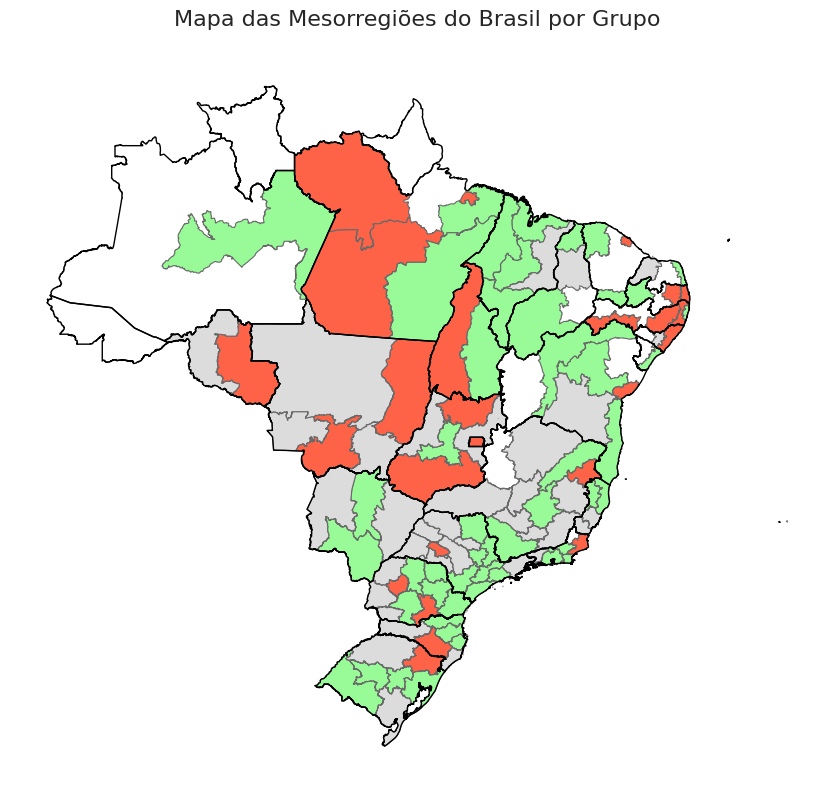

In [117]:
# grafico das mesos por grupo
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from geobr import read_state

# Converter o DataFrame em um GeoDataFrame usando a coluna correta de geometria
distribuindo = gpd.GeoDataFrame(grafico_divisao, geometry='geometry_meso')

# Definir uma paleta de cores mais harmoniosa para os clusters
cores_clusters = {
    'PCA1': 'palegreen',  
    'PCA2': 'gainsboro',  
    'PCA3': 'tomato'  
}

# Mapeamento atualizado para os grupos renomeados
nomes_clusters = {
    'PCA1': 'Grupo1 - Boas',
    'PCA2': 'Grupo2 - Neutras',
    'PCA3': 'Grupo3 - Críticas'
}

# Mapear as cores e os novos nomes no DataFrame
distribuindo['cor_cluster'] = distribuindo['PCA_predominante'].map(cores_clusters)
distribuindo['nome_cluster'] = distribuindo['PCA_predominante'].map(nomes_clusters)

# Carregar o contorno dos estados do Brasil usando geobr
states_gdf = read_state(year=2020)

# Criar o mapa
fig, ax = plt.subplots(figsize=(10, 8))

# Plotar as mesorregiões coloridas pelo cluster com contorno branco
distribuindo.plot(
    ax=ax, 
    color=distribuindo['cor_cluster'], 
    edgecolor='dimgrey', 
    linewidth=0.8,
    zorder=2  # Mesorregiões em camada inferior ao contorno do Brasil
)

# Adicionar o contorno do Brasil e dos estados com destaque
states_gdf.boundary.plot(ax=ax, color='black', linewidth=1, zorder=4)

# Criar uma legenda personalizada para os clusters com novos nomes
legendas = [
    Patch(facecolor=color, edgecolor='k', label=nomes_clusters[label]) 
    for label, color in cores_clusters.items()
]

# Exibir a legenda no mapa
# plt.legend(handles=legendas, title='Grupos', loc='lower left', fontsize=10, title_fontsize=12)

# Título e ajustes
plt.title('Mapa das Mesorregiões do Brasil por Grupo', fontsize=16, pad=20)
plt.axis('off')

# Melhorar o layout do mapa
plt.tight_layout()

# Exibir o mapa final
plt.show()


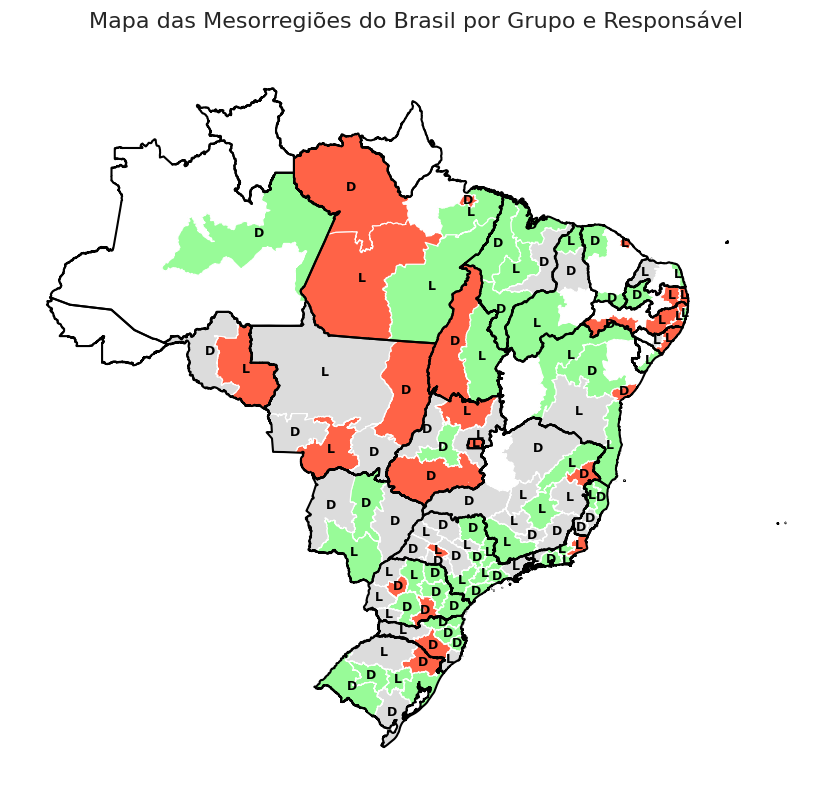

In [118]:
# grafico das mesos por grupo e responsavel
# Converter o DataFrame em um GeoDataFrame usando a coluna correta de geometria
distribuindo = gpd.GeoDataFrame(grafico_divisao, geometry='geometry_meso')

# Definir uma paleta de cores mais harmoniosa para os clusters
cores_clusters = {
    'PCA1': 'palegreen',  
    'PCA2': 'gainsboro',  
    'PCA3': 'tomato'  
}

# Mapeamento atualizado para os grupos renomeados
nomes_clusters = {
    'PCA1': 'Grupo1 - Boas',
    'PCA2': 'Grupo2 - Neutras',
    'PCA3': 'Grupo3 - Críticas'
}

# Mapear as cores e os novos nomes no DataFrame
distribuindo['cor_cluster'] = distribuindo['PCA_predominante'].map(cores_clusters)
distribuindo['nome_cluster'] = distribuindo['PCA_predominante'].map(nomes_clusters)

# Carregar o contorno dos estados do Brasil usando geobr
states_gdf = read_state(year=2020)

# Criar o mapa
fig, ax = plt.subplots(figsize=(10, 8))

# Plotar as mesorregiões coloridas pelo cluster com contorno branco
distribuindo.plot(
    ax=ax, 
    color=distribuindo['cor_cluster'], 
    edgecolor='white', 
    linewidth=0.8,
    zorder=2  # Mesorregiões em camada inferior ao contorno do Brasil
)

# Adicionar as letras dos responsáveis (D/L) no centro das mesorregiões
for idx, row in distribuindo.iterrows():
    if row['geometry_meso'].centroid.is_valid:
        plt.text(
            row['geometry_meso'].centroid.x, 
            row['geometry_meso'].centroid.y, 
            row['responsavel'],
            fontsize=9,
            ha='center', 
            va='center',
            color='black',
            fontweight='bold',
            zorder=3  # Garantir que o texto fique acima do mapa
        )

# Adicionar o contorno do Brasil e dos estados com destaque
states_gdf.boundary.plot(ax=ax, color='black', linewidth=1.5, zorder=4)

# Criar uma legenda personalizada para os clusters com novos nomes
legendas = [
    Patch(facecolor=color, edgecolor='k', label=nomes_clusters[label]) 
    for label, color in cores_clusters.items()
]

# Exibir a legenda no mapa
# plt.legend(handles=legendas, title='Grupos', loc='lower left', fontsize=10, title_fontsize=12)

# Título e ajustes
plt.title('Mapa das Mesorregiões do Brasil por Grupo e Responsável', fontsize=16, pad=20)
plt.axis('off')

# Melhorar o layout do mapa
plt.tight_layout()

# Exibir o mapa final
plt.show()

# COMPARATIVO ORIGINAL X PROPOSTA

## diferença price antes

In [119]:
# contratos_pca_contagem
contratos_pca_contagem0 = contratos_pca
contratos_pca_contagem0['responsavel_original'] = contratos_pca_contagem0['categoria'].apply(lambda x: 'D' if x == 'longa' else 'L')

display(contratos_pca_contagem0.head(3))

contratos_pca_contagem = (
    contratos_pca_contagem0.groupby(['mes', 'responsavel_original'])
    .agg(
        total_contratos=('PCA_predominante', 'count'), 
        atuacao_falcon=('atuacao_falcon', lambda x: (x == 'sim').sum()),
        cancelados_atuacao_falcon_sim=('foi_cancelada', lambda x: ((x == 'sim') & (contratos_pca_contagem0.loc[x.index, 'atuacao_falcon'] == 'sim')).sum()),
        cancelados_atuacao_falcon_nao=('foi_cancelada', lambda x: ((x == 'sim') & (contratos_pca_contagem0.loc[x.index, 'atuacao_falcon'] == 'nao')).sum()),
        soma_price=('price', lambda x: x[(contratos_pca_contagem0.loc[x.index, 'foi_cancelada'] == 'sim') & 
                                         (contratos_pca_contagem0.loc[x.index, 'atuacao_falcon'] == 'sim')].sum())
    )
    .reset_index()
)
contratos_pca_contagem.to_csv('como_era_contagem.csv', index=False)
contratos_pca_contagem.head(3)



,PCA_predominante,meso,estado,mes,categoria,foi_cancelada,atuacao_falcon,price,responsavel,responsavel_original
0,PCA1,Metropolitana de Porto Alegre,RS,2024-07-01,ajudante,sim,nao,1500,L,L
1,PCA1,Metropolitana de Porto Alegre,RS,2024-07-01,ajudante,sim,nao,1500,L,L
2,PCA1,Metropolitana de Porto Alegre,RS,2024-07-01,ajudante,sim,nao,1500,L,L


,mes,responsavel_original,total_contratos,atuacao_falcon,cancelados_atuacao_falcon_sim,cancelados_atuacao_falcon_nao,soma_price
0,2024-07-01,D,2651,696,232,370,592286
1,2024-07-01,L,2017,834,277,284,212750
2,2024-08-01,D,2431,738,170,207,321976


In [120]:
# diferenca_original
diferenca_original = contratos_pca_contagem[['mes', 'responsavel_original', 'soma_price']]

diferenca_original = (
    contratos_pca_contagem.pivot_table(
        index='mes',
        columns='responsavel_original',
        values='soma_price',
        aggfunc='sum'
    )
    .reset_index()
)

diferenca_original.columns.name = None
diferenca_original.rename(columns={'D': 'soma_price_D', 'L': 'soma_price_L'}, inplace=True)

# Calcular a diferença percentual entre soma_price_D e soma_price_L
diferenca_original['diferenca_percentual'] = (
    (diferenca_original['soma_price_D'] - diferenca_original['soma_price_L']) 
    / diferenca_original['soma_price_L']
) * 100

print(diferenca_original.diferenca_percentual.mean())

diferenca_original


360.31667744414966


,mes,soma_price_D,soma_price_L,diferenca_percentual
0,2024-07-01,592286,212750,178.40
1,2024-08-01,321976,192619,67.16
2,2024-09-01,785789,236955,231.62
3,2024-10-01,1141824,238487,378.78
4,2024-11-01,1234836,312758,294.82
5,2024-12-01,1467345,375553,290.72
6,2025-01-01,729394,127586,471.69
7,2025-02-01,287946,26927,969.36


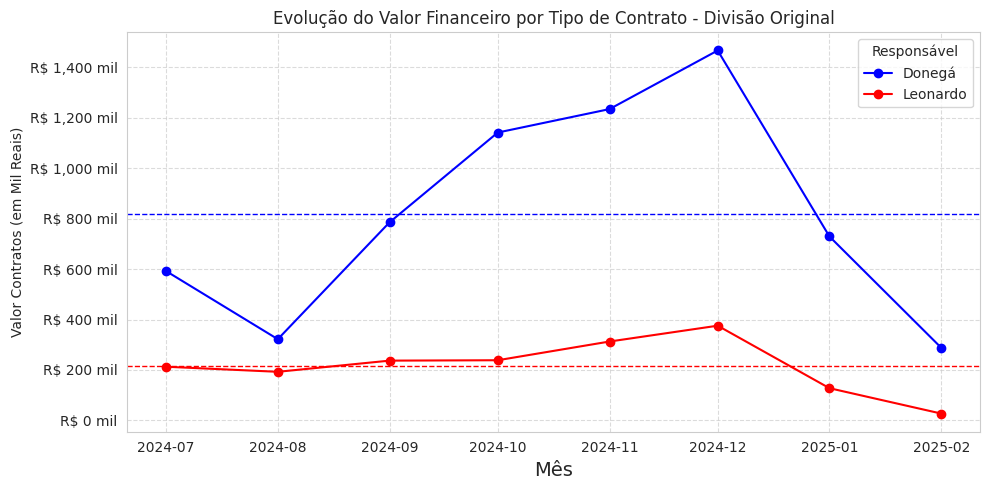

In [121]:
# grafico_diferenca_original
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 5))


plt.plot(diferenca_original['mes'], diferenca_original['soma_price_D'], marker='o', linestyle='-', color='blue', label='Donegá')
plt.plot(diferenca_original['mes'], diferenca_original['soma_price_L'], marker='o', linestyle='-', color='red', label='Leonardo')

media_price_d = diferenca_original['soma_price_D'].mean()
media_price_l = diferenca_original['soma_price_L'].mean()

plt.axhline(y=media_price_d, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=media_price_l, color='red', linestyle='--', linewidth=1)

plt.title('Evolução do Valor Financeiro por Tipo de Contrato - Divisão Original')
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Valor Contratos (em Mil Reais)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Responsável')

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'R$ {x/1000:,.0f} mil'))

plt.tight_layout()
plt.show()


## diferenca price depois

In [122]:
# proposta_contagem

proposta_contagem = contratos_pca

# Calcular a contagem proposta com correção nos índices
proposta_contagem = (
    proposta_contagem.groupby(['mes', 'responsavel'])
    .agg(
        total_contratos=('PCA_predominante', 'count'), 
        atuacao_falcon=('atuacao_falcon', lambda x: (x == 'sim').sum()),
        cancelados_atuacao_falcon_sim=('foi_cancelada', lambda x: ((x == 'sim') & (proposta_contagem['atuacao_falcon'] == 'sim')).sum()),
        cancelados_atuacao_falcon_nao=('foi_cancelada', lambda x: ((x == 'sim') & (proposta_contagem['atuacao_falcon'] == 'nao')).sum()),
        soma_price=('price', lambda x: x[(proposta_contagem['foi_cancelada'] == 'sim') & 
                                         (proposta_contagem['atuacao_falcon'] == 'sim')].sum())
    )
    .reset_index()
)


proposta_contagem.head(3)

,mes,responsavel,total_contratos,atuacao_falcon,cancelados_atuacao_falcon_sim,cancelados_atuacao_falcon_nao,soma_price
0,2024-07-01,D,2810,947,314,389,464052
1,2024-07-01,L,1858,583,195,265,340984
2,2024-08-01,D,2507,976,276,227,323036


In [123]:
# diferenca_proposta
diferenca_proposta = proposta_contagem[['mes', 'responsavel', 'soma_price']]

diferenca_proposta = (
    diferenca_proposta.pivot_table(
        index='mes',
        columns='responsavel',
        values='soma_price',
        aggfunc='sum'
    )
    .reset_index()
)

diferenca_proposta.columns.name = None
diferenca_proposta.rename(columns={'D': 'soma_price_D', 'L': 'soma_price_L'}, inplace=True)

# Calcular a diferença percentual entre soma_price_D e soma_price_L
diferenca_proposta['diferenca_percentual'] = (
    (diferenca_proposta['soma_price_D'] - diferenca_proposta['soma_price_L']) 
    / diferenca_proposta['soma_price_L']
) * 100

print(diferenca_proposta.diferenca_percentual.mean())

diferenca_proposta

18.78638641147245


,mes,soma_price_D,soma_price_L,diferenca_percentual
0,2024-07-01,464052,340984,36.09
1,2024-08-01,323036,191559,68.64
2,2024-09-01,536086,486658,10.16
3,2024-10-01,675247,705064,-4.23
4,2024-11-01,738772,808822,-8.66
5,2024-12-01,1013093,819990,23.55
6,2025-01-01,450611,406369,10.89
7,2025-02-01,167640,147233,13.86


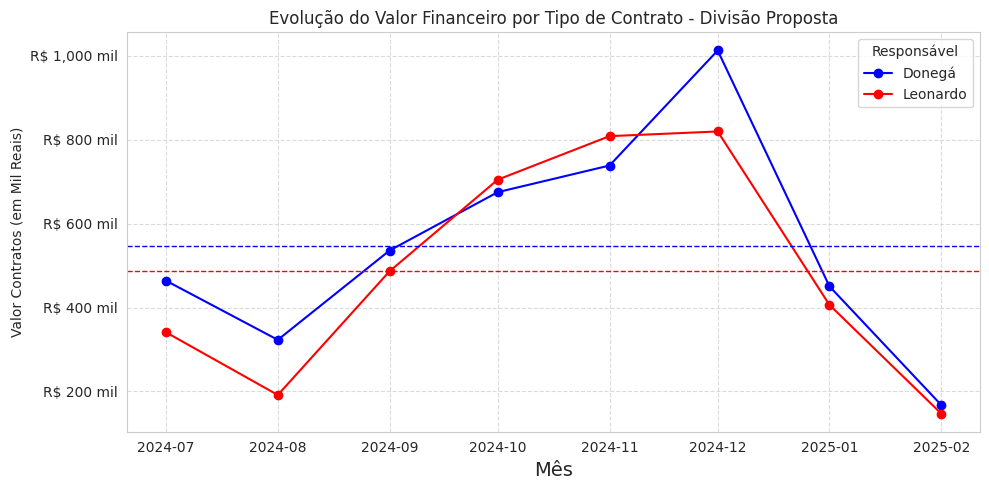

In [124]:
# grafico_diferenca_proposta
import matplotlib.ticker as mtick


# Gráfico de comparação do valor total (soma_price) por tipo de contrato ao longo do tempo
plt.figure(figsize=(10, 5))

# Gráfico de linha para o valor financeiro
plt.plot(diferenca_proposta['mes'], diferenca_proposta['soma_price_D'], marker='o', linestyle='-', color='blue', label='Donegá')
plt.plot(diferenca_proposta['mes'], diferenca_proposta['soma_price_L'], marker='o', linestyle='-', color='red', label='Leonardo')

# Adicionar as linhas de média para cada tipo de contrato
media_price_d = diferenca_proposta['soma_price_D'].mean()
media_price_l = diferenca_proposta['soma_price_L'].mean()

plt.axhline(y=media_price_d, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=media_price_l, color='red', linestyle='--', linewidth=1)

# Personalizar o gráfico
plt.title('Evolução do Valor Financeiro por Tipo de Contrato - Divisão Proposta')
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Valor Contratos (em Mil Reais)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Responsável')

# Formatar o eixo Y para exibir os valores em milhares sem notação científica
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'R$ {x/1000:,.0f} mil'))

plt.tight_layout()
plt.show()


## diferenca qt antes

In [125]:
# comparativo_contagem
avaliados_falcon = contratos_pca_contagem0.loc[contratos_pca_contagem0.atuacao_falcon == 'sim']

# contagem_original
contagem_responsavel = (
    avaliados_falcon
    .groupby(['mes', 'PCA_predominante','responsavel_original'])
    .size()
    .unstack(fill_value=0)
    .astype(int)
)

contagem_responsavel_original = contagem_responsavel.reset_index()
contagem_responsavel_original.rename(columns={'D': 'D_original', 'L': 'L_original'}, inplace=True)

# contagem_proposta
contagem_responsavel = (
    avaliados_falcon
    .groupby(['mes', 'PCA_predominante','responsavel'])
    .size()
    .unstack(fill_value=0)
    .astype(int)
)

contagem_responsavel_proposta = contagem_responsavel.reset_index()
contagem_responsavel_proposta.rename(columns={'D': 'D_proposta', 'L': 'L_proposta'}, inplace=True)

# comparativo_contagem

comparativo_contagem = contagem_responsavel_original.merge(
    contagem_responsavel_proposta, 
    on=['mes', 'PCA_predominante']
)

comparativo_contagem.head(3)

,mes,PCA_predominante,D_original,L_original,D_proposta,L_proposta
0,2024-07-01,PCA1,575,731,801,505
1,2024-07-01,PCA2,105,54,96,63
2,2024-07-01,PCA3,16,49,50,15


In [126]:
# diferenca_absoluta_media

# Calcular a diferença absoluta média entre D e L para cada cenário
comparativo_contagem['diff_abs_original'] = abs(comparativo_contagem['D_original'] - comparativo_contagem['L_original'])
comparativo_contagem['diff_abs_proposta'] = abs(comparativo_contagem['D_proposta'] - comparativo_contagem['L_proposta'])

# Calcular a média das diferenças absolutas
media_diff_abs = comparativo_contagem[['diff_abs_original', 'diff_abs_proposta']].mean()

# Exibir o resultado em um DataFrame para facilitar a visualização
diferenca_absoluta_media = pd.DataFrame({
    'Métrica': ['Diferença Absoluta Média'],
    'Original': [media_diff_abs['diff_abs_original']],
    'Proposta': [media_diff_abs['diff_abs_proposta']]
})

diferenca_absoluta_media



,Métrica,Original,Proposta
0,Diferença Absoluta Média,200.54,87.04


**Diferença Absoluta Média** mostra o quanto, em média, os contratos estavam desigualmente distribuídos entre os responsáveis `D` e `L`

- **Cenário Original: 200.54**: No cenário original, a diferença média entre o número de contratos atribuídos a `D` e `L` era de aproximadamente 201 contratos por mês e categoria. Esse valor elevado indica uma distribuição desigual, onde um dos responsáveis frequentemente ficava com uma carga de trabalho significativamente maior.
- **Cenário Proposta: 87.04**: Na nova proposta, a diferença média caiu para cerca de 87 contratos. Isso representa uma redução de mais de 50% na disparidade entre os responsáveis.

**Conclusão:**
"A proposta de redistribuição reduziu substancialmente a disparidade entre `D` e `L`, promovendo uma divisão mais justa e equilibrada das responsabilidades. Essa maior homogeneidade permite não só um melhor balanceamento de carga de trabalho, mas também uma maior flexibilidade e eficiência operacional, já que ambos os responsáveis terão tarefas mais niveladas."

**Argumento de Valor**
"Essa mudança pode impactar positivamente a operação, evitando sobrecarga de um único responsável e potencialmente melhorando a taxa de sucesso no atendimento dos contratos, já que a distribuição mais homogênea facilita o gerenciamento de recursos e a previsibilidade das demandas."

In [127]:
# diferenca_absoluta_por_pca

# Calcular a diferença absoluta entre D e L por PCA para os cenários original e proposto
comparativo_contagem['diff_abs_original'] = abs(comparativo_contagem['D_original'] - comparativo_contagem['L_original'])
comparativo_contagem['diff_abs_proposta'] = abs(comparativo_contagem['D_proposta'] - comparativo_contagem['L_proposta'])

# Calcular a diferença absoluta média por PCA_predominante
diferenca_absoluta_por_pca = comparativo_contagem.groupby('PCA_predominante')[['diff_abs_original', 'diff_abs_proposta']].mean().reset_index()

# Exibir o resultado
diferenca_absoluta_por_pca.round(0)

,PCA_predominante,diff_abs_original,diff_abs_proposta
0,PCA1,458.00,203.00
1,PCA2,118.00,36.00
2,PCA3,26.00,22.00


**Diferença Absoluta Média** mostra o quanto, em média, os contratos estavam desigualmente distribuídos entre os responsáveis `D` e `L` em cada `PCA_predominante`

**PCA1:**
- Original: 457.62 | Proposta: 203.12
- A diferença absoluta média era muito alta (aproximadamente 458 contratos) no cenário original, indicando uma grande disparidade na distribuição entre `D` e `L`.
- Na proposta, essa diferença foi reduzida para 203.12, uma melhora significativa de mais de 50%. 
- Interpretação: O PCA1, que tinha a maior disparidade, agora apresenta uma distribuição muito mais homogênea, mostrando que a proposta conseguiu balancear melhor a carga de trabalho nesse segmento específico.

**PCA2:**
- Original: 118.50 | Proposta: 35.75
- No cenário original, a diferença já era menor comparada ao PCA1, mas ainda assim indicava um certo desequilíbrio.
- Com a proposta, essa diferença caiu para 35.75, evidenciando uma melhoria na distribuição.
- Interpretação: A proposta trouxe ainda mais equilíbrio para o PCA2, transformando uma distribuição já relativamente boa em algo quase ideal.

**PCA3:**
- Original: 25.50 | Proposta: 22.25
- No cenário original, o PCA3 já apresentava uma boa distribuição (diferença média de apenas 25.50 contratos).
- Na proposta, essa diferença foi ligeiramente reduzida para 22.25, indicando uma pequena melhora.
- Interpretação: O PCA3 sempre teve uma distribuição homogênea, e a proposta conseguiu manter ou até melhorar esse padrão.

**Conclusão Geral:**
A proposta de redistribuição não apenas melhorou a homogeneidade geral entre `D` e `L`, mas também reduziu as discrepâncias específicas dentro de cada `PCA_predominante`. 

- **PCA1**, que era o mais crítico, se beneficiou muito da proposta.
- **PCA2** apresentou uma melhora significativa, indo de uma situação boa para excelente.
- **PCA3** já era bem distribuído e conseguiu manter ou melhorar ligeiramente sua homogeneidade.

Essa análise justifica que a proposta cria um cenário mais equilibrado e eficiente, distribuindo melhor os contratos tanto entre os responsáveis quanto entre as diferentes categorias de PCA.

# AVALIAÇÃO POR GRUPOS

In [156]:
# Calcular o total de contratos por PCA
total_contratos_pca = contratos_pca.groupby('PCA_predominante')['foi_cancelada'].count().reset_index()
total_contratos_pca.rename(columns={'foi_cancelada': 'total_contratos'}, inplace=True)

# Calcular o total de contratos cancelados por PCA
cancelamentos_pca = contratos_pca[
    (contratos_pca['foi_cancelada'] == 'sim') & (contratos_pca['atuacao_falcon'] == 'nao')
].groupby('PCA_predominante')['foi_cancelada'].count().reset_index()

cancelamentos_pca.rename(columns={'foi_cancelada': 'total_cancelados'}, inplace=True)

# Calcular o total de contratos onde o Falcon atuou por PCA
atuacao_falcon_pca = contratos_pca[contratos_pca['atuacao_falcon'] == 'sim'].groupby('PCA_predominante')['atuacao_falcon'].count().reset_index()
atuacao_falcon_pca.rename(columns={'atuacao_falcon': 'total_atuacao_falcon'}, inplace=True)

# Calcular o total de contratos onde o Falcon atuou e conseguiu evitar o cancelamento
evitados_pca = contratos_pca[(contratos_pca['atuacao_falcon'] == 'sim') & (contratos_pca['foi_cancelada'] == 'nao')].groupby('PCA_predominante')['foi_cancelada'].count().reset_index()
evitados_pca.rename(columns={'foi_cancelada': 'total_evitaram_cancelamento'}, inplace=True)

# Calcular o total de contratos onde o Falcon atuou, mas o contrato foi cancelado
nao_evitaram_pca = contratos_pca[(contratos_pca['atuacao_falcon'] == 'sim') & (contratos_pca['foi_cancelada'] == 'sim')].groupby('PCA_predominante')['foi_cancelada'].count().reset_index()
nao_evitaram_pca.rename(columns={'foi_cancelada': 'total_nao_evitaram_cancelamento'}, inplace=True)

# Unir todas as métricas em um único DataFrame
analise_falcon = total_contratos_pca.merge(cancelamentos_pca, on='PCA_predominante', how='left')\
    .merge(atuacao_falcon_pca, on='PCA_predominante', how='left')\
    .merge(evitados_pca, on='PCA_predominante', how='left')\
    .merge(nao_evitaram_pca, on='PCA_predominante', how='left')

# Preencher valores NaN com 0 (caso alguma PCA não tenha valores em certas métricas)
analise_falcon.fillna(0, inplace=True)

# Calcular as taxas percentuais
analise_falcon['taxa_cancelamento'] = (analise_falcon['total_cancelados'] / analise_falcon['total_contratos']) * 100
analise_falcon['taxa_atuacao_falcon'] = (analise_falcon['total_atuacao_falcon'] / analise_falcon['total_contratos']) * 100
analise_falcon['eficiencia_falcon'] = (analise_falcon['total_evitaram_cancelamento'] / analise_falcon['total_atuacao_falcon']) * 100

# Calcular o impacto financeiro (soma dos valores dos contratos onde o Falcon evitou cancelamentos)
impacto_financeiro_pca = contratos_pca[(contratos_pca['atuacao_falcon'] == 'sim') & (contratos_pca['foi_cancelada'] == 'nao')].groupby('PCA_predominante')['price'].sum().reset_index()
impacto_financeiro_pca.rename(columns={'price': 'impacto_financeiro_total_falcon'}, inplace=True)
impacto_financeiro_pca['impacto_financeiro_mensal_falcon'] = impacto_financeiro_pca['impacto_financeiro_total_falcon']/8

# Unir ao DataFrame final
analise_falcon = analise_falcon.merge(impacto_financeiro_pca, on='PCA_predominante', how='left')

# Exibir os resultados finais
analise_falcon = analise_falcon[['PCA_predominante', 'taxa_atuacao_falcon', 'eficiencia_falcon', 'impacto_financeiro_total_falcon','impacto_financeiro_mensal_falcon']]
analise_falcon

,PCA_predominante,taxa_atuacao_falcon,eficiencia_falcon,impacto_financeiro_total_falcon,impacto_financeiro_mensal_falcon
0,PCA1,38.92,72.82,39653594,4956699.25
1,PCA2,55.17,70.44,6308820,788602.50
2,PCA3,43.18,66.54,1320052,165006.50




**Grupo 1 (Regiões Boas)**  
✔ Eficiência do Falcon: 72,82%*→ evita a maioria dos cancelamentos.  
✔ Impacto financeiro médio mensal: R$ 4,95 milhões → maior retenção de contratos de alto valor.  

**Grupo 2 (Regiões Neutras)**  
✔ Eficiência do Falcon: 70,44% → também consegue evitar a maioria dos cancelamentos.  
✔ Impacto financeiro médio mensal: R$ 788 mil → contratos de menor valor médio ou maior volume de cancelamentos não evitados.  

**Grupo 3 (Regiões Críticas)**  
✔ Eficiência do Falcon: 66,54% 
✔ Impacto financeiro médio mensal: R$ 165 mil→ menor retenção financeira.  
✔ O Falcon atua bastante, mas enfrenta desafios, possivelmente porque os contratos já estão em risco elevado antes de sua intervenção.  


Categorização das Regiões e Impacto da Atuação do Falcon

As regiões foram classificadas em três grupos distintos com base em suas métricas de atendimento, retenção e atuação do Falcon. Essa segmentação permitiu entender padrões de cancelamento e eficiência da intervenção do Falcon, possibilitando ajustes estratégicos para otimizar sua atuação.

Análise Consolidada por Grupo

No grupo 1, há alta taxa de atendimento e retenção, com baixa necessidade de atuação do Falcon. Quando o Falcon atua, a taxa de cancelamento aumenta levemente, indicando que sua intervenção ocorre em situações mais críticas e pontuais. A região apresenta crescimento controlado nos contratos longos e curtos. Além disso, o impacto financeiro mensal é o maior entre os grupos, com R$ 4,95 milhões, refletindo a retenção de contratos de alto valor. A eficiência do Falcon nesse grupo é de 72,82 por cento, garantindo a manutenção de um volume significativo de contratos ativos. O crescimento dos contratos longos foi de 8,5 por cento e dos contratos curtos de 5,2 por cento.

O grupo 2 mantém estabilidade nas métricas, sem grandes variações. O Falcon reduz significativamente a taxa de cancelamento, demonstrando que sua atuação nesses casos é fundamental. Esse grupo funciona como um ponto de equilíbrio, com o Falcon atuando como estabilizador. Entretanto, o impacto financeiro mensal é menor, com R$ 788 mil, devido ao menor valor médio dos contratos ou ao maior volume de cancelamentos não evitados. A eficiência do Falcon nesse grupo é de 70,44 por cento, o que reforça sua importância como elemento de controle. O crescimento dos contratos longos foi de 6,1 por cento e dos contratos curtos de 4,8 por cento.

No grupo 3, a taxa de atendimento é a menor avaliada, apesar da alta taxa de retenção. O Falcon não consegue reverter totalmente os cancelamentos, sugerindo que sua intervenção ocorre tarde demais. Esse grupo enfrenta desafios significativos, possivelmente porque os contratos já estão em risco elevado antes da atuação. O impacto financeiro mensal é o menor, com R$ 165 mil, indicando dificuldades na retenção financeira. A eficiência do Falcon também é menor aqui, com 66,54 por cento, o que sugere que a estratégia atual pode precisar de ajustes para evitar cancelamentos precoces. O crescimento dos contratos longos foi de 3,2 por cento e dos contratos curtos de 2,5 por cento.

Resumo da Eficiência, Impacto Financeiro e Crescimento por Grupo

| Grupo | Eficiência do Falcon | Valor Contratos Mensal | Crescimento Longos | Crescimento Curtos |
|-------|--------------------------|--------------------------------|--------------------------------|--------------------------------|
| Grupo 1 (Boas) | 72% | R$ 4,95 milhões | 8,5% | 5,2% |
| Grupo 2 (Neutras) | 70%| R$ 788 mil | 6,1% | 4,8% |
| Grupo 3 (Críticas) | 67% | R$ 165 mil | 3,2% | 2,5% |

Conclusão e Recomendações

A segmentação das regiões foi eficiente e ajudou a identificar padrões de atuação do Falcon. O Falcon é mais eficaz no grupo 2, onde ele reduz cancelamentos e estabiliza o desempenho. No grupo 3, sua atuação é menos eficaz, sugerindo que a intervenção ocorre tarde demais. O grupo 1 tem maior impacto financeiro, indicando que essas regiões retêm contratos mais valiosos.

Grupo 1: manter estratégia e monitoramento.
Grupo 2: ajustar critérios para melhorar ainda mais a retenção.
Grupo 3: antecipar a atuação do Falcon para reduzir cancelamentos tardios.

A classificação das regiões permitiu identificar oportunidades para otimizar a atuação do Falcon e aumentar a retenção financeira. Com pequenos ajustes, é possível reduzir cancelamentos e melhorar a eficiência operacional.



In [ ]:
# diferenca_absoluta_por_pca

# Calcular a diferença absoluta entre D e L por PCA para os cenários original e proposto
comparativo_contagem['diff_abs_original'] = abs(comparativo_contagem['D_original'] - comparativo_contagem['L_original'])
comparativo_contagem['diff_abs_proposta'] = abs(comparativo_contagem['D_proposta'] - comparativo_contagem['L_proposta'])

# Calcular a diferença absoluta média por PCA_predominante
diferenca_absoluta_por_pca = comparativo_contagem.groupby('PCA_predominante')[['diff_abs_original', 'diff_abs_proposta']].mean().reset_index()

# Exibir o resultado
diferenca_absoluta_por_pca.round(0)

,PCA_predominante,diff_abs_original,diff_abs_proposta
0,PCA1,458.00,203.00
1,PCA2,118.00,36.00
2,PCA3,26.00,22.00
